<a href="https://colab.research.google.com/github/akalakheti/captiongenerator/blob/master/CaptionGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Caption Generator using TensorFlow

Import all the required libraries.

Note: We won't be using TensorFlow 2.0 for this notebook because the 
trained model is in .pb format which is not compatible in TF2.

In [0]:

import tensorflow as tf
import numpy as np
import heapq

In [0]:
import os
import math

Mounting google drive to use the trained model saved in the google drive. Link to the model:

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
def download_and_unzip_model():
  save_path = '/content/model.pb'
  gdd.download_file_from_google_drive(file_id='15Juh0gaYR0qv8GjRL1EvsigErdQXTmnt',
                                    dest_path=save_path,
                                    unzip=True)
 
download_and_unzip_model()

Unzipping...Done.


This is a data storage class. It is used as a data structure to save different variables for prediction.

In [0]:
class DataStorer(object):
   def __init__(self, sentence, state, logprob, score):
        self.sentence = sentence
        self.state = state
        self.logprob = logprob
        self.score = score


Let's create a class named TopNElements. We have to create this in order to maintain the top n (number of generated captions) elements of an incrementally provided set. The push method pushes a new element. The extract method will extract all the saved top elements and the reset method will bring the elements storing array to default state. 

In [0]:
class TopNElements(object):

    def __init__(self, n):
      self._n = n
      self._data = []

    def add(self, x):
      if len(self._data) < self._n:
        heapq.heappush(self._data, x)
      else:
        heapq.heappushpop(self._data, x)
    
    def extract(self):
      data = self._data
      self._data = None
      data.sort(reverse=True)
      return data

    def size(self):
      return len(self._data)

    def reset(self):
      self._data = []


Vocab class to handle words in words_count.txt file

In [0]:
class Vocab(object):
  
  def __init__(self, vocab_path):
    
    with open(vocab_path, mode="r") as file:
      reverse_vocab_list = list(file.readlines())
    reverse_vocab_list = [line.split()[0] for line in reverse_vocab_list]

    vocab_list = dict([(x, y) for (y, x) in enumerate(reverse_vocab_list)])
        
    self.vocab_list = vocab_list
    self.reverse_vocab_list = reverse_vocab_list

    self.start_id = vocab_list["<S>"]
    self.end_id = vocab_list["</S>"]

  def idx2word(self, token_id):
    return self.reverse_vocab_list[token_id]

The model class to load the .pb file setup the model for the program.

In [0]:
class Model(object):
    def __init__(self, model_path):
        self._model_path = model_path
        self._load_model(model_path)
        self._sess = tf.Session(graph=tf.get_default_graph())

    def _load_model(self, frozen_graph_path):
        model = os.path.expanduser(frozen_graph_path)
        
        with tf.gfile.FastGFile(model, 'rb') as f:
          graph_def = tf.GraphDef()
          graph_def.ParseFromString(f.read())
          tf.import_graph_def(graph_def, name='')


    def send_img(self, encoded_image):
        initial_state = self._sess.run(fetches="lstm/initial_state:0",
                                       feed_dict={"image_feed:0": encoded_image})
        return initial_state

    def prediction(self, input_feed, state_feed):
        pred, state_output = self._sess.run(
            fetches=["softmax:0", "lstm/state:0"],
            feed_dict={
                "input_feed:0": input_feed,
                "lstm/state_feed:0": state_feed,
            })
        return pred, state_output


creating the instance of ShowAndTellModel and Vocabulary class to pass it to the instance of CaptionGenerator.

In [0]:
from google.colab import files
files.upload()

Saving words_count.txt to words_count.txt


{'words_count.txt': b'a 969108\r\n</S> 586368\r\n<S> 586368\r\n. 440479\r\non 213612\r\nof 202290\r\nthe 196219\r\nin 182598\r\nwith 152984\r\nand 139109\r\nis 97322\r\nman 72712\r\nto 67506\r\nsitting 52259\r\nan 49463\r\ntwo 47993\r\n, 43921\r\nstanding 42264\r\nat 42204\r\npeople 41672\r\nare 40768\r\nnext 36794\r\nwhite 35874\r\nwoman 33849\r\nstreet 30173\r\ntable 29681\r\nthat 27969\r\nholding 27648\r\nit 26574\r\nperson 24540\r\nlarge 24417\r\nsome 24130\r\ndown 22912\r\ntop 21994\r\ngroup 21582\r\nup 20742\r\nfield 20614\r\nsmall 19884\r\ntennis 19485\r\nnear 19450\r\nhis 19304\r\nfront 19296\r\nblack 19187\r\ntrain 18217\r\ndog 18107\r\nplate 18081\r\nriding 18081\r\nroom 18076\r\nred 17185\r\nyoung 16971\r\ncat 16933\r\nby 16864\r\nwater 16374\r\nbaseball 15472\r\nhas 14974\r\nwhile 14551\r\nplaying 14504\r\nwalking 14492\r\nbathroom 14339\r\nsign 14028\r\nblue 13618\r\nkitchen 13244\r\nfood 13049\r\ngrass 12917\r\nthere 12678\r\nbus 12554\r\ngreen 12484\r\nparked 12436\r\npi

Creating Instance of Model and Vocab class.

In [0]:
model = Model('/content/show-and-tell.pb')
vocab = Vocab('/content/words_count.txt')

Uploading image to notebook.

In [0]:
from google.colab import files
files.upload()

Saving a.jpg to a.jpg


{'a.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\x00\x

Give the path for the image to generate caption.

In [0]:
image_path = '/content/a.jpg'

Visualizing the image.

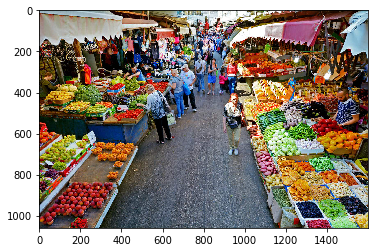

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()


This is the beam search algorithm. The major processing of the system happens here.

Note: This portion is inspired from TensorFlow's official im2txt model.

Link to original code: https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/inference_utils/caption_generator.py

In [0]:

def beam_search(encoded_image, model, vocab):
  
  beam_size=1                    #No. of captions to generate.
  max_sentence_length=20


  partial_caption_beam = TopNElements(beam_size)

  complete_captions = TopNElements(beam_size)

  init_state = model.send_img(encoded_image)    

  initial_beam = DataStorer(
            sentence=[vocab.start_id],
            state=init_state[0],
            logprob=0.0,
            score=0.0)

  partial_caption_beam.add(initial_beam)

        # Run beam search.
  for _ in range(max_sentence_length - 1):
    part_caption_list = partial_caption_beam.extract()
    partial_caption_beam.reset()
    input_feed = np.array([item.sentence[-1] for item in part_caption_list])
    state_feed = np.array([item.state for item in part_caption_list])

    pred, new_states = model.prediction(input_feed, state_feed)

    for i, partial_caption in enumerate(part_caption_list):
      word_probabilities = pred[i]
      state = new_states[i]
                # Predict the next word.
      words_and_probs = list(enumerate(word_probabilities))
      words_and_probs.sort(key=lambda x: -x[1])
      words_and_probs = words_and_probs[0:beam_size]
                # iterating over predicted words.
      for w, p in words_and_probs:
        if p < 1e-12:
          continue  
        sentence = partial_caption.sentence + [w]    #creating list of words
        logprob = partial_caption.logprob + math.log(p)
        score = logprob

        if w == vocab.end_id:  #if the words end, then save to complete_caption else save to partial_caption.
          beam = DataStorer(sentence, state, logprob, score)
          complete_captions.add(beam)
        else:
          beam = DataStorer(sentence, state, logprob, score)
          partial_caption_beam.add(beam)

    if partial_caption_beam.size() == 0:
        break

  if complete_captions.size() == 0:
      complete_captions = partial_caption_beam


  captions = complete_captions.extract()

 #combining words.
  for caption in captions:
    sentence = [vocab.idx2word(w) for w in caption.sentence[1:-1]]
    sentence = " ".join(sentence)
  return sentence




finally encoding the image file and passing it to beam_search function to generate caption.

In [0]:
with tf.gfile.GFile(image_path, "rb") as f:
  image = f.read()

cap = beam_search(image,model,vocab)


In [0]:
print(cap)

a market with lots of fruits and vegetables .


As we could see, the model predicted the caption to be a market with lots of fruits and vegetables which is true.